In [1]:
# Setup: imports and device
import os
import math
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from datasets import load_dataset
from huggingface_hub import snapshot_download
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

d:\AIT\computervision\project\imageSegmentation\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [ ]:
out_dir = Path('data_seg')
out_dir.mkdir(exist_ok=True)
ds = load_dataset('PuTorch/DesignEarth', split='train', streaming=True)
saved = 0
max_samples = 800  
for i, ex in enumerate(ds):
    if saved >= max_samples:
        break
    img = None
    for k in ('image','img','image_path','picture'):
        if k in ex:
            img = ex[k]
            break
    if img is None:
        continue
    # Convert huggingface Image object or bytes -> PIL
    try:
        if hasattr(img, 'to_bytes'):
            pil = Image.open(img.to_bytes()).convert('RGB')
        elif isinstance(img, (bytes, bytearray)):
            from io import BytesIO
            pil = Image.open(BytesIO(img)).convert('RGB')
        elif isinstance(img, str) and os.path.exists(img):
            pil = Image.open(img).convert('RGB')
        else:
            try:
                pil = img.to_pil()
            except Exception:
                pil = Image.fromarray(np.array(img)).convert('RGB')
    except Exception as e:
        print('skip example, cannot read image:', e)
        continue
    # Save image
    img_path = out_dir / f'image_{saved:04d}.jpg'
    pil.save(img_path)


Got disconnected from remote data host. Retrying in 5sec [1/20]
'The read operation timed out' thrown while requesting GET https://huggingface.co/datasets/PuTorch/DesignEarth/resolve/57ac8fef95b276c07f390d180945d4af45f27488/train/DesignEarth-train-00009-of-00010.parquet
Retrying in 1s [Retry 1/5].
'The read operation timed out' thrown while requesting GET https://huggingface.co/datasets/PuTorch/DesignEarth/resolve/57ac8fef95b276c07f390d180945d4af45f27488/train/DesignEarth-train-00009-of-00010.parquet
Retrying in 1s [Retry 1/5].


Either Test_before or Test_after folder is missing. Create both with matching filenames.
Saved 0 examples to results_damage


In [ ]:
from pathlib import Path
import csv
import numpy as _np
import cv2
import torchvision.transforms.functional as TF

before_dir = Path('Test_before')
after_dir = Path('Test_after')
out_dir = Path('results_damage')
out_dir.mkdir(exist_ok=True)

def predict_mask(img_pil, model, transform, device):
    x = transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        out = torch.sigmoid(model(x)).detach().cpu()
    # resize to original image size
    out_resized = TF.resize(out, img_pil.size[::-1])
    mask = (out_resized.squeeze(0).squeeze(0).numpy() > 0.5).astype('uint8')
    return mask

def iou_mask(a, b):
    inter = ((a>0) & (b>0)).sum()
    union = ((a>0) | (b>0)).sum()
    if union == 0:
        return 1.0 if inter==0 else 0.0
    return float(inter) / float(union)

# transforms used (same as train)
infer_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

if not before_dir.exists() or not after_dir.exists():
    print('Either Test_before or Test_after folder is missing. Create both with matching filenames.')
else:
    before_files = {p.name: p for p in sorted(before_dir.glob('*')) if p.suffix.lower() in ('.jpg','.jpeg','.png','.bmp','.tif','.tiff')}
    after_files = {p.name: p for p in sorted(after_dir.glob('*')) if p.suffix.lower() in ('.jpg','.jpeg','.png','.bmp','.tif','.tiff')}
    common = sorted(set(before_files.keys()) & set(after_files.keys()))
    print('Found', len(common), 'matching before/after image pairs')
    summary_path = out_dir / 'damage_summary.csv'
    rows = []
    # USE_ENSEMBLE
    USE_ENSEMBLE = False
    for i, name in enumerate(common):
        bpath = before_files[name]
        apath = after_files[name]
        ib = Image.open(bpath).convert('RGB')
        ia = Image.open(apath).convert('RGB')
        mask_b = predict_mask(ib, unet, infer_transform, device)
        mask_a = predict_mask(ia, unet, infer_transform, device)
        if USE_ENSEMBLE:
            m2_b = predict_mask(ib, resnet_seg, infer_transform, device)
            m2_a = predict_mask(ia, resnet_seg, infer_transform, device)
            mask_b = ((mask_b>0) | (m2_b>0)).astype('uint8')
            mask_a = ((mask_a>0) | (m2_a>0)).astype('uint8')
        # compute IoU and area change
        iou = iou_mask(mask_b, mask_a)
        area_b = float((mask_b>0).sum())
        area_a = float((mask_a>0).sum())
        area_change = 0.0 if area_b == 0 else (area_b - area_a) / area_b
        # simple damage heuristics: IoU below threshold or area drop > threshold
        iou_thresh = 0.6
        area_drop_thresh = 0.3
        damaged = (iou < iou_thresh) or (area_change > area_drop_thresh)

        wb = _np.array(ib).copy()
        wa = _np.array(ia).copy()
        wb[mask_b>0, 0] = _np.maximum(wb[mask_b>0, 0], 200)
        wa[mask_a>0, 0] = _np.maximum(wa[mask_a>0, 0], 200)
        # concat horizontally
        concat = _np.concatenate([wb, wa], axis=1)
        flag = 'DAMAGED' if damaged else 'OK'
        color = (0,0,255) if damaged else (0,255,0)
        cv2.putText(concat, f'{name}  {flag}  IoU={iou:.2f}  drop={area_change:.2f}', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)
        out_p = out_dir / f'damage_{i:04d}_{name}'
        Image.fromarray(concat).save(str(out_p))
        rows.append({'file': name, 'iou': iou, 'area_before': area_b, 'area_after': area_a, 'area_change': area_change, 'damaged': int(damaged)})
    # write CSV summary
    with open(summary_path, 'w', newline='') as f:
        w = csv.DictWriter(f, fieldnames=['file','iou','area_before','area_after','area_change','damaged'])
        w.writeheader()
        w.writerows(rows)
    print('Damage summary written to', summary_path)
    # Try to save mask if present
    mask_saved = False
    for mk in ('mask','segmentation','label','annotation'):
        if mk in ex:
            m = ex[mk]
            try:
                if hasattr(m, 'to_pil'):
                    mp = m.to_pil().convert('L')
                elif isinstance(m, (bytes, bytearray)):
                    from io import BytesIO
                    mp = Image.open(BytesIO(m)).convert('L')
                else:
                    mp = Image.fromarray(np.array(m)).convert('L')
                mpath = out_dir / f'mask_{saved:04d}.png'
                mp.save(mpath)
                mask_saved = True
                break
            except Exception:
                pass
    if not mask_saved:
        gray = pil.convert('L')
        arr = np.array(gray)
        th = arr.mean()
        mask_arr = (arr > th).astype(np.uint8) * 255
        Image.fromarray(mask_arr).save(out_dir / f'mask_{saved:04d}.png')
    saved += 1
print('Saved', saved, 'examples to', out_dir)

In [ ]:
# Dataset class and transforms
class SegDataset(Dataset):
    def __init__(self, root, split='train', size=(256,256)):
        self.root = Path(root)
        self.images = sorted(list(self.root.glob('image_*.jpg')))
        self.masks = sorted(list(self.root.glob('mask_*.png')))
        self.size = size
        self.transform_img = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize(size, interpolation=Image.NEAREST),
            transforms.ToTensor()  # produces (1,H,W) in [0,1]
        ])
    def __len__(self):
        return min(len(self.images), len(self.masks))
    def __getitem__(self, idx):
        im = Image.open(self.images[idx]).convert('RGB')
        m = Image.open(self.masks[idx]).convert('L')
        im_t = self.transform_img(im)
        m_t = (self.transform_mask(m) > 0.5).float()
        return im_t, m_t


dataset = SegDataset('data_seg', size=(256,256))
n = len(dataset)
train_n = int(n * 0.9)
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_n, n - train_n])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0)
print('Dataset size:', n, 'train:', len(train_ds), 'val:', len(val_ds))

Dataset size: 800 train: 720 val: 80


## Model: U-Net (compact)

In [4]:
# Compact U-Net implementation (same style as earlier notebook)
def conv(in_c, out_c):
    return nn.Sequential(nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
def up_conv(in_c, out_c):
    return nn.Sequential(nn.ConvTranspose2d(in_c, out_c, 2, stride=2), nn.ReLU(inplace=True))
class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.enc1 = nn.Sequential(conv(in_ch, 32), conv(32,32))
        self.pool = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(conv(32,64), conv(64,64))
        self.enc3 = nn.Sequential(conv(64,128), conv(128,128))
        self.center = nn.Sequential(conv(128,256), conv(256,256))
        self.up3 = up_conv(256,128)
        self.dec3 = nn.Sequential(conv(256,128), conv(128,128))
        self.up2 = up_conv(128,64)
        self.dec2 = nn.Sequential(conv(128,64), conv(64,64))
        self.up1 = up_conv(64,32)
        self.dec1 = nn.Sequential(conv(64,32), conv(32,32))
        self.out = nn.Conv2d(32, out_ch, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        c = self.center(self.pool(e3))
        d3 = self.up3(c)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        out = self.out(d1)
        return out

unet = UNetSmall().to(device)
print(unet)

UNetSmall(
  (enc1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## Model: ResNet34 encoder + simple decoder

In [5]:
class ResNetSeg(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained=True, out_ch=1):
        super().__init__()
        # load torchvision resnet as encoder
        res = models.resnet34(pretrained=pretrained)
        # keep layers up to layer4
        self.stem = nn.Sequential(res.conv1, res.bn1, res.relu, res.maxpool)
        self.layer1 = res.layer1
        self.layer2 = res.layer2
        self.layer3 = res.layer3
        self.layer4 = res.layer4
        # decoder: simple upsampling with convs
        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec4 = nn.Sequential(nn.Conv2d(512,256,3,padding=1), nn.ReLU(inplace=True))
        self.up3 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.dec3 = nn.Sequential(nn.Conv2d(256,128,3,padding=1), nn.ReLU(inplace=True))
        self.up2 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec2 = nn.Sequential(nn.Conv2d(128,64,3,padding=1), nn.ReLU(inplace=True))
        self.up1 = nn.ConvTranspose2d(64,64,2,stride=2)
        self.dec1 = nn.Sequential(nn.Conv2d(128,64,3,padding=1), nn.ReLU(inplace=True))
        self.out = nn.Conv2d(64, out_ch, 1)
    def forward(self, x):
        s = self.stem(x)          # /4
        l1 = self.layer1(s)      # /4
        l2 = self.layer2(l1)     # /8
        l3 = self.layer3(l2)     # /16
        l4 = self.layer4(l3)     # /32
        u4 = self.up4(l4)
        d4 = self.dec4(torch.cat([u4, l3], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, l2], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, l1], dim=1))
        u1 = self.up1(d2)
        # to match size, concatenate original early features if shapes align (safe fallback)
        # here we don't have an exact e1 map; proceed with u1
        out = self.out(u1)
        return out

resnet_seg = ResNetSeg(pretrained=False).to(device)
print(resnet_seg)

ResNetSeg(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu):

## Training helpers (loss, train/validate loops)

In [ ]:
from pathlib import Path
mask_files = sorted(Path('data_seg').glob('mask_*.png'))
sample_values = {}
for mf in mask_files[:20]:
    arr = np.array(Image.open(mf).convert('L'))
    uniq = np.unique(arr)
    sample_values[mf.name] = uniq.tolist()
print('Sample mask unique values (first 20):')
for k,v in sample_values.items():
    print(k, v)
print('By default any non-zero pixel will be treated as a house. If your masks use class ids, set HOUSE_LABEL to that integer and re-run this cell.')
HOUSE_LABEL = None 
def load_binary_mask(path):
    arr = np.array(Image.open(path).convert('L'))
    if HOUSE_LABEL is None:
        binm = (arr > 0).astype(np.uint8) * 255
    else:
        binm = (arr == HOUSE_LABEL).astype(np.uint8) * 255
    return Image.fromarray(binm)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super().__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        # preds: logits (N,1,H,W), targets: binary (N,1,H,W)
        probs = torch.sigmoid(preds)
        probs = probs.view(-1)
        targets = targets.view(-1)
        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1. - dice

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()
def loss_fn(preds, targets):
    l_bce = bce_loss(preds.squeeze(1), targets.squeeze(1))
    l_dice = dice_loss(preds, targets)
    return 0.5 * l_bce + 0.5 * l_dice

Sample mask unique values (first 20):
mask_0000.png [0, 255]
mask_0001.png [0, 255]
mask_0002.png [0, 255]
mask_0003.png [0, 255]
mask_0004.png [0, 255]
mask_0005.png [0, 255]
mask_0006.png [0, 255]
mask_0007.png [0, 255]
mask_0008.png [0, 255]
mask_0009.png [0, 255]
mask_0010.png [0, 255]
mask_0011.png [0, 255]
mask_0012.png [0, 255]
mask_0013.png [0, 255]
mask_0014.png [0, 255]
mask_0015.png [0, 255]
mask_0016.png [0, 255]
mask_0017.png [0, 255]
mask_0018.png [0, 255]
mask_0019.png [0, 255]
By default any non-zero pixel will be treated as a house. If your masks use class ids, set HOUSE_LABEL to that integer and re-run this cell.


In [8]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        if logits.shape[-2:] != y.shape[-2:]:
            logits = nn.functional.interpolate(logits, size=y.shape[-2:], mode='bilinear', align_corners=False)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader):
    model.eval()
    total_loss = 0.0
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        if logits.shape[-2:] != y.shape[-2:]:
            logits = nn.functional.interpolate(logits, size=y.shape[-2:], mode='bilinear', align_corners=False)
        loss = loss_fn(logits, y)
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

In [ ]:
def quick_train(model, epochs=2, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    for e in range(epochs):
        tr = train_epoch(model, train_loader, opt)
        val = validate(model, val_loader)
        print(f'Epoch {e+1}/{epochs} Train loss: {tr:.4f} Val loss: {val:.4f}')

unet.to(device)
resnet_seg.to(device)
print('Training U-Net (small)')
quick_train(unet, epochs=2, lr=1e-3)
print('Training ResNet encoder-decoder')
quick_train(resnet_seg, epochs=2, lr=1e-3)

Training U-Net (small)
Epoch 1/2 Train loss: 0.4651 Val loss: 0.4560
Epoch 1/2 Train loss: 0.4651 Val loss: 0.4560
Epoch 2/2 Train loss: 0.4133 Val loss: 0.4169
Training ResNet encoder-decoder
Epoch 2/2 Train loss: 0.4133 Val loss: 0.4169
Training ResNet encoder-decoder
Epoch 1/2 Train loss: 0.5412 Val loss: 0.5802
Epoch 1/2 Train loss: 0.5412 Val loss: 0.5802
Epoch 2/2 Train loss: 0.4918 Val loss: 0.5038
Epoch 2/2 Train loss: 0.4918 Val loss: 0.5038


## Visual comparison
Show original, ground-truth mask, UNet prediction, ResNet prediction side-by-side for several validation samples.

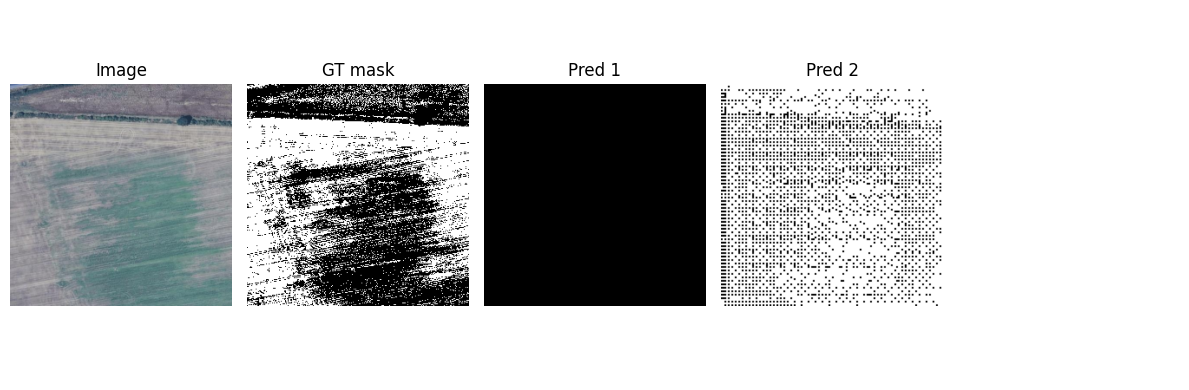

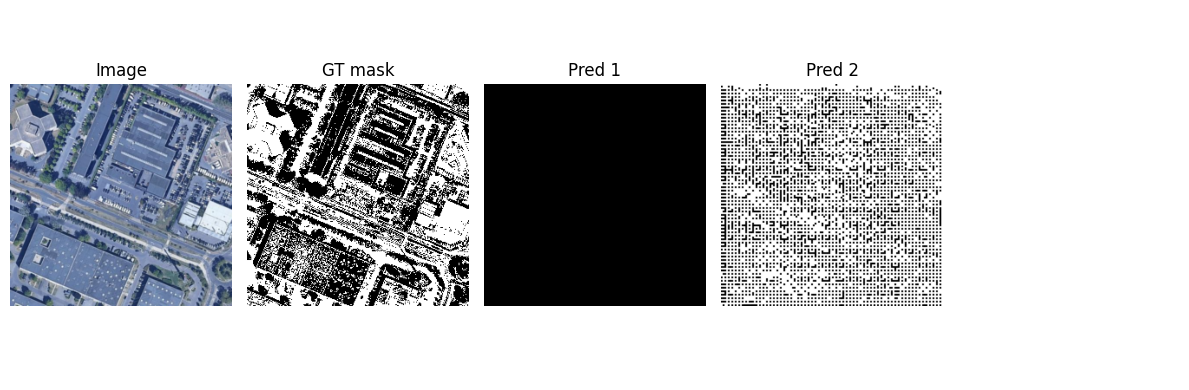

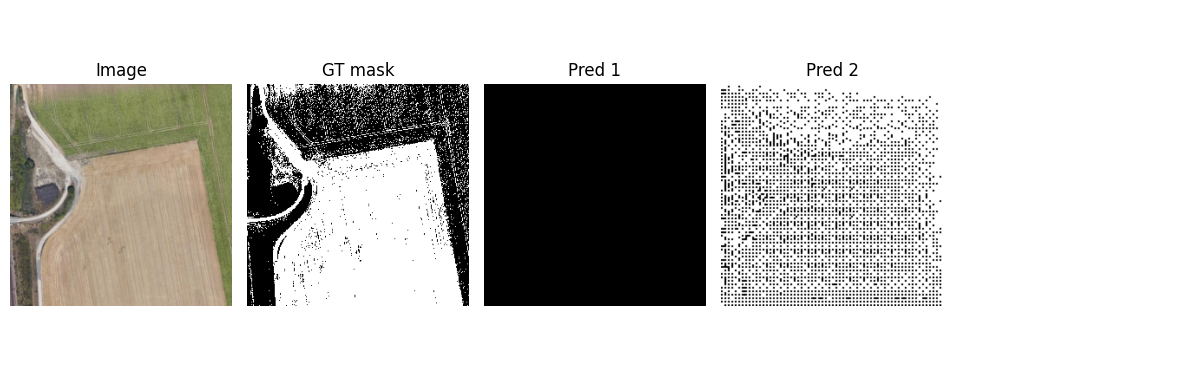

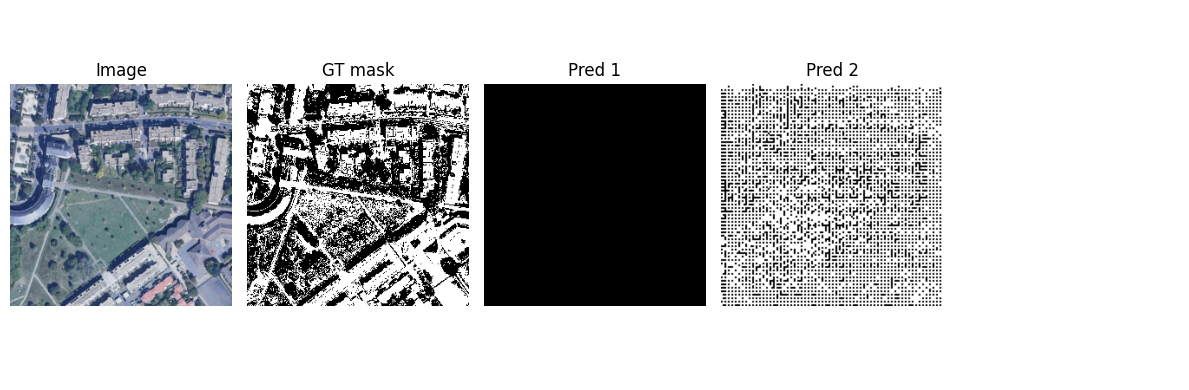

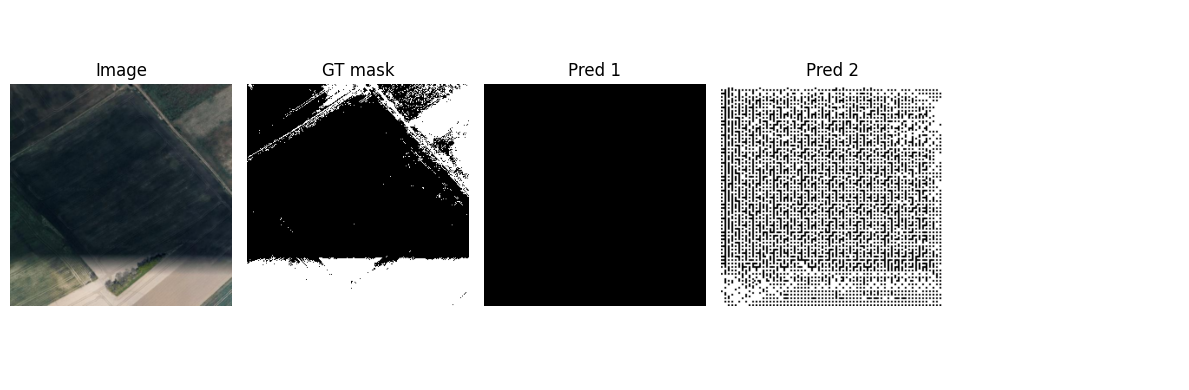

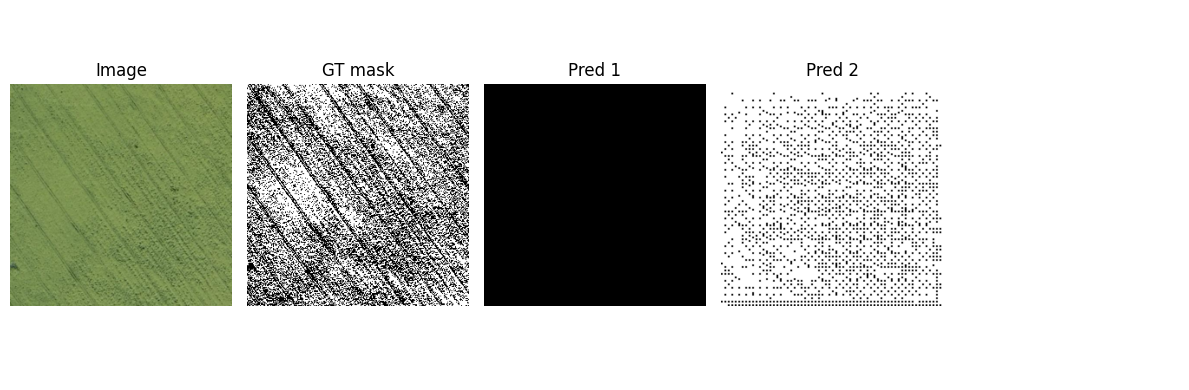

In [ ]:
import torchvision
def show_predictions(models, loader, n=6):
    models = [m.eval() for m in models]
    imgs = []
    for i, (x,y) in enumerate(loader):
        if i >= n:
            break
        x = x.to(device)
        outs = [torch.sigmoid(m(x)).detach() for m in models]
        for j in range(x.size(0)):
            img = x[j].cpu()
            gt = y[j].cpu().squeeze(0).numpy()
            preds = [o[j].cpu().squeeze(0).numpy() for o in outs]
            imgs.append((img, gt, preds))
    for idx, (img, gt, preds) in enumerate(imgs[:n]):
        fig, axs = plt.subplots(1, 3+len(preds), figsize=(12,4))
        mean = np.array([0.485,0.456,0.406])[:,None,None]
        std = np.array([0.229,0.224,0.225])[:,None,None]
        im = img.numpy()
        im = (im * std + mean).transpose(1,2,0)
        axs[0].imshow(np.clip(im,0,1))
        axs[0].set_title('Image')
        axs[1].imshow(gt, cmap='gray')
        axs[1].set_title('GT mask')
        for k, p in enumerate(preds):
            axs[2+k].imshow(p>0.5, cmap='gray')
            axs[2+k].set_title(f'Pred {k+1}')
        for a in axs: a.axis('off')
        plt.tight_layout()
        plt.show()

show_predictions([unet, resnet_seg], val_loader, n=6)

In [ ]:
from pathlib import Path
test_dir = Path('Test')
if not test_dir.exists():
    print('Test folder not found at', test_dir)
else:
    exts = ['*.jpg','*.jpeg','*.png','*.bmp','*.tif','*.tiff']
    files = []
    for p in exts:
        files.extend(sorted(test_dir.glob(p)))
    print('Found', len(files), 'test images in', test_dir)
    out_dir = Path('results_test')
    out_dir.mkdir(exist_ok=True)
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    import torchvision.transforms.functional as TF
    for i,p in enumerate(files):
        im = Image.open(p).convert('RGB')
        x = transform(im).unsqueeze(0).to(device)
        with torch.no_grad():
            out_u = torch.sigmoid(unet(x)).detach().cpu()
            out_r = torch.sigmoid(resnet_seg(x)).detach().cpu()
        out_u_resized = TF.resize(out_u, im.size[::-1])
        out_r_resized = TF.resize(out_r, im.size[::-1])
        mask_u = (out_u_resized.squeeze(0).squeeze(0).numpy() > 0.5).astype('uint8') * 255
        mask_r = (out_r_resized.squeeze(0).squeeze(0).numpy() > 0.5).astype('uint8') * 255
        Image.fromarray(mask_u).save(out_dir / f'pred_unet_{i:04d}.png')
        Image.fromarray(mask_r).save(out_dir / f'pred_resnet_{i:04d}.png')
        arr_u = np.array(im).copy()
        arr_u[mask_u==255, 0] = np.maximum(arr_u[mask_u==255, 0], 200)  # red
        arr_u[mask_u==255, 1] = np.minimum(arr_u[mask_u==255, 1], 80)
        Image.fromarray(arr_u).save(out_dir / f'overlay_unet_{i:04d}.png')
        arr_r = np.array(im).copy()
        arr_r[mask_r==255, 0] = np.maximum(arr_r[mask_r==255, 0], 200)
        arr_r[mask_r==255, 1] = np.minimum(arr_r[mask_r==255, 1], 80)
        Image.fromarray(arr_r).save(out_dir / f'overlay_resnet_{i:04d}.png')
        Image.fromarray(mask_u).save(out_dir / f'label_unet_{i:04d}.png')
        Image.fromarray(mask_r).save(out_dir / f'label_resnet_{i:04d}.png')
    print('Saved predictions for', len(files), 'images to', out_dir)

Found 6 test images in Test
Saved predictions for 6 images to results_test
Saved predictions for 6 images to results_test
